##### Setup the Environment

In [1]:
# append the site-packages for the vision-environment

import sys
sys.path.append('C:\\Users\\PrateekTripathi\\Anaconda3\\envs\\vision\\lib\\site-packages')

In [2]:
# import the required libraries

import cv2                                           # OpenCV
import numpy as np
import random
import json
import torch
import torchvision
import collections
import matplotlib.pyplot as plt

from pathlib import Path                             # for defining the path

##### Get Images with their Annotations

In [3]:
# read the .json file waith the details of the images

PATH = Path('VOC2012')

image_details = json.load((PATH/'pascal_train2012.json').open())

let's explore this .json file

In [4]:
len(image_details)

4

In [5]:
image_details.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
print("Images:\t\t", len(image_details['images']))
print("Type:\t\t", len(image_details['type']))
print("Annotations:\t", len(image_details['annotations']))
print("Categories:\t", len(image_details['categories']))

Images:		 5717
Type:		 9
Annotations:	 15774
Categories:	 20


In [7]:
test_image = image_details['images'][0]

print(test_image)

{'file_name': '2008_000008.jpg', 'height': 442, 'width': 500, 'id': 2008000008}


In [8]:
print(image_details['categories'])

object_categories = dict((i['id'], i['name']) for i in image_details['categories'])

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}, {'supercategory': 'none', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'none', 'id': 3, 'name': 'bird'}, {'supercategory': 'none', 'id': 4, 'name': 'boat'}, {'supercategory': 'none', 'id': 5, 'name': 'bottle'}, {'supercategory': 'none', 'id': 6, 'name': 'bus'}, {'supercategory': 'none', 'id': 7, 'name': 'car'}, {'supercategory': 'none', 'id': 8, 'name': 'cat'}, {'supercategory': 'none', 'id': 9, 'name': 'chair'}, {'supercategory': 'none', 'id': 10, 'name': 'cow'}, {'supercategory': 'none', 'id': 11, 'name': 'diningtable'}, {'supercategory': 'none', 'id': 12, 'name': 'dog'}, {'supercategory': 'none', 'id': 13, 'name': 'horse'}, {'supercategory': 'none', 'id': 14, 'name': 'motorbike'}, {'supercategory': 'none', 'id': 15, 'name': 'person'}, {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'}, {'supercategory': 'none', 'id': 17, 'name': 'sheep'}, {'supercategory': 'none', 'id': 18, 'name': 'sofa'}, {'supercategory': 'none',

In [9]:
object_categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [10]:
image_file_names = dict((i['id'], i['file_name']) for i in image_details['images'])

In [11]:
image_details['annotations'][0]

{'segmentation': [[52, 86, 52, 420, 471, 420, 471, 86]],
 'area': 139946,
 'iscrowd': 0,
 'image_id': 2008000008,
 'bbox': [52, 86, 419, 334],
 'category_id': 13,
 'id': 1,
 'ignore': 0}

In [12]:
# define a function to return annotations

def get_annotations(dataset):
    
    return_annotations = collections.defaultdict(lambda: [])
    for i in dataset['annotations']:
        
        if not i['ignore']:
            
            bb = i['bbox']
            bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
            
            return_annotations[i['image_id']].append((bb, i['category_id']))
            
    return return_annotations

image_annotations = get_annotations(image_details)

In [13]:
JPEGS = 'JPEGImages'                                 # figure out the path to the images
IMAGES_PATH = 'VOC2012/' + JPEGS                     # define the path for images

In [14]:
def bb_original(bb): return np.array([bb[1], bb[0], bb[3] - bb[1] + 1, bb[2] - bb[0] + 1])

##### Select and Display an Image with its Bounding Boxes

In [15]:
# define a function to draw the image along with its bounding boxes

def draw_rect(image, coords, color = None):
    """draw the rectangle on the image
    
    image: numpy.ndarray    
    coords: numpy.ndarray
        bounding boxes are represented in the format `y1 x1 y2 x2`
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it"""
    
    image = image.copy()
    
    if not color:
        color = [255,255,255]
        
    for coord in coords:
        
        # print(coord)
        
        pt1, pt2 = (coord[1], coord[0]) , (coord[3], coord[2])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        image = cv2.rectangle(image.copy(), pt1, pt2, color, int(max(image.shape[:2]) / 200))
                            
                            # (image, point-one, point-two, color, thickness)
        
    return image

In [16]:
# define a function to display an image at a specific index

def draw_image(i, transforms = None):
    
    image_id = image_details['images'][i]['id']         # get the image id from the images .json for the position
    file_name = image_file_names[image_id]              # get the name of the file from train_fnames dictionary
    bounding_boxes = image_annotations[image_id]        # fetch the bounding boxes from train_annotations default dict
    
    bboxes = [list(bb[0]) for bb in bounding_boxes]
    
    image_path = IMAGES_PATH + '/' + file_name
    
    image = cv2.imread(image_path)[:, :, ::-1]          # OpenCV uses BGR channels
    
    if transforms != None:
        
        transforms = transforms
        image, bboxes = transforms(image, bboxes)
        
    plt.figure(figsize = (16, 8))

    plt.imshow(draw_rect(image, bboxes))

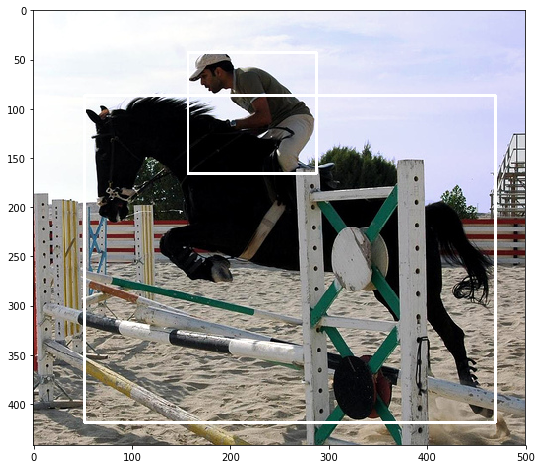

In [17]:
draw_image(0)

##### Horizontal Flip

In [18]:
# define a class for performing random horizontal flips

class RandomHorizontalFlip():

    """randomly horizontally flips the image with the probability *p*
    
    p: float
        the probability with which the image is flipped
    
    numpy.ndaaray
        flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `y1, x1, y2, x2` of the box"""

    def __init__(self, p = 0.5):
        
        self.p = p

    def __call__(self, image, bboxes):
        
        image_center = np.array(image.shape[ :2]) / 2
        image_center = np.hstack((image_center, image_center))
        bboxes = np.array(bboxes).astype(float)
        
        if random.random() < self.p:
            
            image = image[:, ::-1, :]
            
            bboxes[:, [1, 3]] += 2 * (image_center[[1, 3]] - bboxes[:, [1, 3]])
            box_w = abs(bboxes[:, 1] - bboxes[:, 3])
            bboxes[:, 1] -= box_w
            bboxes[:, 3] += box_w

        return image, bboxes

let's test horizontal flips

In [19]:
transforms = RandomHorizontalFlip(1)

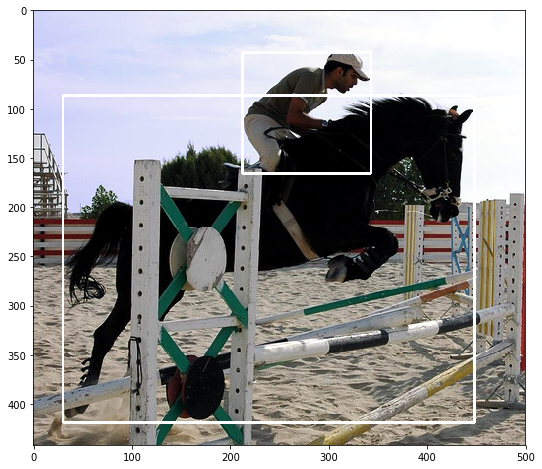

In [20]:
draw_image(0, transforms)

##### Scale

In [21]:
def bbox_area(bbox):
    
    return (bbox[:,2] - bbox[:,0]) * (bbox[:,3] - bbox[:,1])

In [22]:
def clip_box(bbox, clip_box, alpha):
    """clip the bounding boxes to the borders of an image
    
    bbox: numpy.ndarray
        numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `y1 x1 y2 x2`
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `y1 x1 y2 x2`
    alpha: float
        if the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    numpy.ndarray
        numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]

    return bbox

In [23]:
class RandomScale():
    """randomly scales an image    
    
    bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image are dropped; rhe resolution is maintained, and the remaining
    area if any is filled by black color
    
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
    
    numpy.ndaaray
        scaled image in the numpy format of shape `HxWxC`
    numpy.ndarray
        tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `y1, x1, y2, x2` of the box"""

    def __init__(self, scale = 0.2, diff = False, size = 0):
        
        self.scale = scale
        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "invalid range"
            assert self.scale[0] > -1, "scale factor can't be less than -1"
            assert self.scale[1] > -1, "scale factor can't be less than -1"
        else:
            assert self.scale > 0, "please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff
        self.size = size

    def __call__(self, image, bboxes):
    
        #chose a random digit to scale by 
        
        image_shape = image.shape
        
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x

        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        bboxes = np.array(bboxes).astype(float)
        
        if self.size == 0:
            
            image = cv2.resize(image, None, fx = resize_scale_x, fy = resize_scale_y)
            
            bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
            canvas = np.zeros(image_shape, dtype = np.uint8)
        
            y_lim = int(min(resize_scale_y, 1) * image_shape[0])
            x_lim = int(min(resize_scale_x, 1) * image_shape[1])
        
            canvas[ :y_lim, :x_lim, : ] =  image[ :y_lim, :x_lim, :]
        
            image = canvas
            bboxes = clip_box(bboxes, [0, 0, 1 + image_shape[1], image_shape[0]], 0.25)
            
        else:
            
            bboxes[:, [0, 2]] *= (self.size[1] / image.shape[0])
            bboxes[:, [1, 3]] *= (self.size[0] / image.shape[1])
            
            image = cv2.resize(image, self.size)
    
        return image, bboxes

In [24]:
transform_scale_size = RandomScale(size = (224, 224))

transform_scale_factor = RandomScale()

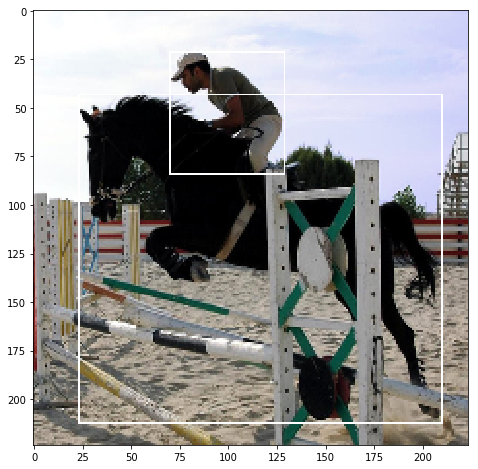

In [25]:
draw_image(0, transform_scale_size)

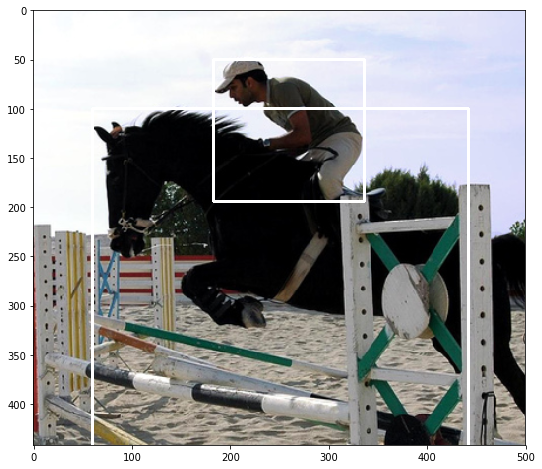

In [26]:
draw_image(0, transform_scale_factor)

##### Translation

In [27]:
class RandomTranslate():
    """randomly translates the image    
    
    bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image are dropped; the resolution is maintained, and the remaining
    area if any is filled by black color
    
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
    
    numpy.ndaaray
        translated image in the numpy format of shape `HxWxC`
    numpy.ndarray
        tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box"""

    def __init__(self, translate = 0.2, diff = False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1

        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
        self.diff = diff

    def __call__(self, image, bboxes):
        
        #chose a random digit to scale by 
        image_shape = image.shape
        
        bboxes = np.array(bboxes).astype(float)
        
        #translate the image
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(image_shape).astype(np.uint8)
    
        corner_x = int(translate_factor_x * image.shape[1])
        corner_y = int(translate_factor_y * image.shape[0])
        
        #change the origin to the top-left corner of the translated box
        orig_box_coords =  [max(0, corner_y), 
                            max(corner_x, 0), 
                            min(image_shape[0], corner_y + image.shape[0]), 
                            min(image_shape[1],corner_x + image.shape[1])]
    
        mask = image[max(-corner_y, 0):min(image.shape[0], -corner_y + image_shape[0]), 
                     max(-corner_x, 0):min(image.shape[1], -corner_x + image_shape[1]), :]
        
        canvas[orig_box_coords[0]:orig_box_coords[2], 
               orig_box_coords[1]:orig_box_coords[3], :] = mask
        
        image = canvas
        
        bboxes[:, :4] += [corner_x, corner_y, corner_x, corner_y]
        
        bboxes = clip_box(bboxes, [0,0,image_shape[1], image_shape[0]], 0.25)
        
        return image, bboxes

In [28]:
transform_translate = RandomTranslate()

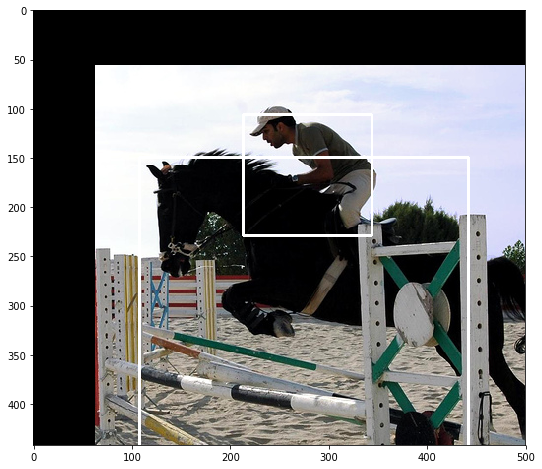

In [29]:
draw_image(0, transform_translate)

##### Rotation

In [30]:
def rotate_image(image, angle):
    """rotate the image.
    
    rotate the image such that the rotated image is enclosed inside the tightest
    rectangle; the area not occupied by the pixels of the original image is colored
    black
    
    image : numpy.ndarray
        numpy image
    angle : float
        angle by which the image is to be rotated
    
    numpy.ndarray
        rotated image"""
    
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    return image

In [31]:
def get_corners(bboxes):
    """get corners of bounding boxes
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`"""
    
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [32]:
def rotate_box(corners, angle, cx, cy, h, w):
    """rotate the bounding box.
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
    h : int 
        height of the image
    w : int 
        width of the image
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`"""

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0], 1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    
    # Prepare the vector to be transformed
    calculated = np.dot(M, corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [33]:
def get_enclosing_box(corners):
    """get an enclosing box for ratated corners of a bounding box
    
    corners : numpy.ndarray
        numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    numpy.ndarray
        numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`"""
    
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final

In [34]:
class RandomRotate():
    """randomly rotates an image    
    
    bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
    
    numpy.ndaaray
        rotated image in the numpy format of shape `HxWxC`
    numpy.ndarray
        tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box"""

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, image, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = image.shape[1], image.shape[0]
        cx, cy = w//2, h//2
        
        bboxes = np.array(bboxes).astype(float)
    
        image = rotate_image(image, angle)
    
        corners = get_corners(bboxes)
        corners = np.hstack((corners, bboxes[:,4:]))
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
        scale_factor_x = image.shape[1] / w
        scale_factor_y = image.shape[0] / h
    
        image = cv2.resize(image, (w, h))
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes = new_bbox
        bboxes = clip_box(bboxes, [0, 0, w, h], 0.25)
    
        return image, bboxes

In [35]:
transform_rotate = RandomRotate(5)

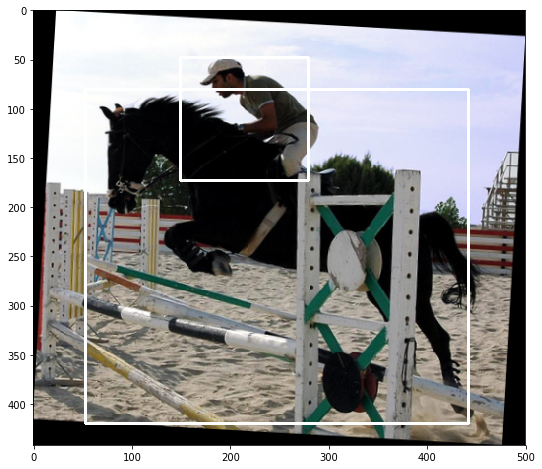

In [36]:
draw_image(0, transform_rotate)